# TorchVision 0.3 Object Detection Template for IDTReeS

For this tutorial, we will be finetuning a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model.

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In [2]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-ar2eegci
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-ar2eegci
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263913 sha256=d9220f8ee3381ff497a11ca553be91995b3a9cdcc567d19e4d5f6fde339ca992
  Stored in directory: /tmp/pip-ephem-wheel-cache-8109j8gk/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


### Setting up the IDTrees Dataset

Here we set up the data set from IDTrees:

In [1]:
%%shell

# download the IDTrees dataset
wget https://zenodo.org/record/3934932/files/IDTREES_competition_test_v2.zip .
# extract it in the current folder
unzip IDTREES_competition_test_v2.zip

wget https://zenodo.org/record/3934932/files/IDTREES_competition_train_v2.zip .
unzip IDTREES_competition_train_v2.zip

--2021-05-07 01:35:59--  https://zenodo.org/record/3934932/files/IDTREES_competition_test_v2.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242074557 (231M) [application/octet-stream]
Saving to: ‘IDTREES_competition_test_v2.zip’

IDTREES_competition 100%[===================>] 230.86M  8.87MB/s    in 31s     

2021-05-07 01:36:32 (7.37 MB/s) - ‘IDTREES_competition_test_v2.zip’ saved [242074557/242074557]

--2021-05-07 01:36:32--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2021-05-07 01:36:32--
Total wall clock time: 33s
Downloaded: 1 files, 231M in 31s (7.37 MB/s)
Archive:  IDTREES_competition_test_v2.zip
  inflating: neon_aop_bands.csv      
   creating: task1/
   creating: task1/RemoteSensing/
   creating: task1/RemoteSensing/CHM/
  inflating: task1/RemoteSensing/CHM/MLBS

In [3]:
%%shell
pip install rasterio
pip install geopandas
pip install pyshp

     |████████████████████████████████| 19.1MB 1.2MB/s 
     |████████████████████████████████| 1.0MB 8.8MB/s 
     |████████████████████████████████| 6.5MB 27.3MB/s 
     |████████████████████████████████| 15.3MB 208kB/s 
     |████████████████████████████████| 225kB 7.4MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.3-cp37-none-any.whl size=37264 sha256=b0a8750debedca5c5775c0825b55a922801f6f8fe02d14acf707b1a7fbf31226
  Stored in directory: /root/.cache/pip/wheels/76/2b/d4/53e6b9a0fb0a9f9f29664cf82605af8bc81d5ab44d987896dd
Successfully built pyshp


In [4]:
import os
import random
import re

import numpy as np
import pandas as pd
import torch
import torch.utils.data # ???
import rasterio
import shapefile # pip3 install pyshp

from PIL import Image

## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


Let's write a `torch.utils.data.Dataset` class for this dataset.

In [32]:
from collections import defaultdict

class IDTreesDataset(torch.utils.data.Dataset):
    def __init__(self, rgb_path, transforms=None,
                 mlbs_shp_path = "train/ITC/train_MLBS",
                 osbs_shp_path = "train/ITC/train_OSBS",
                 csv_path = "train/Field/itc_rsFile.csv"):

        # Directory of .tif RGB images
        self.rgb_path = rgb_path

        # Transforms to apply to the images (for example, for data augmentation)
        self.transforms = transforms

        # Load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(self.rgb_path)))
        self.imgs = [filename.strip('.tif') for filename in self.imgs if '.tif' in filename]

        # Necessary in order to convert bounding boxes to pixels
        self.imgs_transform = dict()

        # Load bounding boxes
        self.bboxes = dict()
        self.bbox_shapes = self.__read_bboxes(mlbs_shp_path, osbs_shp_path, csv_path)
        
    
    def __load_img(self, idx):
        img_name = self.imgs[idx]
        img_path = os.path.join(self.rgb_path, f'{img_name}.tif')

        with rasterio.open(img_path) as rasterio_img:
            h, w = rasterio_img.read(1).shape
            self.imgs_transform[img_name]=rasterio_img.transform
    
            # 3 color channels in RGB
            img_array = np.zeros((h, w, 3))
            for i in range(3):
                band = rasterio_img.read(i+1)
                img_array[:, :, i] = band
    
            img_array = img_array.astype(np.uint8)
            img = Image.fromarray(img_array)
            return img

    def __read_bboxes(self, mlbs_shp_path, osbs_shp_path, csv_path):
        mlbs_shape = shapefile.Reader(mlbs_shp_path)
        osbs_shape = shapefile.Reader(osbs_shp_path)

        refs = pd.read_csv(csv_path)
        refs['rsFile'] =  [re.sub("\.tif.*$", "", x) for x in refs['rsFile']]
        key_to_name = dict(zip(refs['indvdID'], refs['rsFile']))
    
        record_shapes = defaultdict(list)
        for feature in mlbs_shape.shapeRecords():
            name = key_to_name[feature.record.indvdID]
            record_shapes[name].append(feature.shape.bbox)
        for feature in osbs_shape.shapeRecords():
            name = key_to_name[feature.record.indvdID]
            record_shapes[name].append(feature.shape.bbox)

        return record_shapes

    def __get_bboxes(self, idx):

        img_name = self.imgs[idx]

        # Check if we already computed the boxes 
        if img_name in self.bboxes:
            return self.bboxes[img_name]
        
        # Compute the boxes
        boxes = []
        transform = self.imgs_transform[img_name]
        for v in self.bbox_shapes[img_name]:
            rows, cols = rasterio.transform.rowcol(transform,[v[0],v[2]], [v[1],v[3]])
            #NOTE should this need to be switched? - need to follow up with Rebekah
            boxes.append([rows[1],cols[0],rows[0],cols[1]])
        self.bboxes[img_name] = boxes
        return boxes
    

    def __getitem__(self, idx):
        img_name = self.imgs[idx]

        img   = self.__load_img(idx)
        boxes = self.__get_bboxes(idx)

        # Note: do this step every time. do not save the tensor in self.bboxes
        #       or else you will crash
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # There is only one class
        labels = torch.ones((len(boxes),), dtype=torch.int64)

        image_id = torch.tensor([idx])
        if len(boxes) > 0:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            boxes = torch.as_tensor([[0.0,0.0,0.1,0.1]], dtype=torch.float32)
            area = torch.as_tensor([0.0], dtype=torch.float32) 
            labels = torch.ones((len(boxes),), dtype=torch.int64)
            print("SOMETHING IS WRONG", self.imgs[idx])
        
        # Suppose all instances are not crowd
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        if len(boxes) < 1:
            print(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

<PIL.Image.Image image mode=RGB size=200x200 at 0x7F50FC6217D0> {'boxes': tensor([[  0., 161.,  29., 199.],
        [  2.,   0.,  46.,  39.],
        [ 13.,  51.,  56.,  99.],
        [ 35.,  27.,  73.,  60.],
        [ 19.,  60.,  78., 145.],
        [ 56., 136.,  90., 180.],
        [  7., 132.,  66., 199.],
        [ 63., 154., 114., 199.],
        [ 35.,   0., 113.,  30.],
        [ 66.,  91., 112., 144.],
        [ 90., 116., 129., 157.],
        [128.,  48., 190.,  90.],
        [103.,  70., 139., 111.],
        [128.,  84., 196., 155.],
        [130., 157., 173., 199.],
        [126.,  30., 176.,  54.],
        [ 75.,  67., 105.,  94.],
        [ 44.,   4., 131.,  76.],
        [123.,   3., 159.,  30.],
        [  0.,  70.,  15., 122.],
        [157., 156., 196., 199.],
        [  5.,  33.,  45.,  61.]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'image_id': tensor([0]), 'area': tensor([1102., 1716., 2064., 1254., 5015., 1496., 3953., 

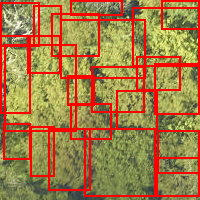

In [33]:
dataset = IDTreesDataset('./train/RemoteSensing/RGB/')

img, target = dataset[0]
print(img, target)

from PIL import Image, ImageDraw

bb_img = img
bb_draw_img = ImageDraw.Draw(bb_img)

boxes = target['boxes']
for box in boxes:
  box = [int(coord) for coord in box]
  shape = [(box[1], box[0]), (box[3], box[2])]
  bb_draw_img.rectangle(shape, outline ="red", width=2)

print(len(boxes))
bb_img

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

## Defining your model

In this tutorial, we will be using [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

![Mask R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image04.png)

There are two common situations where one might want to modify one of the available models in torchvision modelzoo.
The first is when we want to start from a pre-trained model, and just finetune the last layer. The other is when we want to replace the backbone of the model with a different one (for faster predictions, for example).

Let's go see how we would do one or another in the following sections.


### 1 - Finetuning from a pretrained model

Let's suppose that you want to start from a model pre-trained on COCO and want to finetune it for your particular classes. Here is a possible way of doing it:
```
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
```

### 2 - Modifying the model to add a different backbone

Another common situation arises when the user wants to replace the backbone of a detection
model with a different one. For example, the current default backbone (ResNet-50) might be too big for some applications, and smaller models might be necessary.

Here is how we would go into leveraging the functions provided by torchvision to modify a backbone.

```
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios 
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)
```

### An Instance segmentation model for PennFudan Dataset

In our case, we want to fine-tune from a pre-trained model, given that our dataset is very small. So we will be following approach number 1.

Here we want to also compute the instance segmentation masks, so we will be using Mask R-CNN:

In [34]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [35]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be376084 version check against PyTorch's CUDA version




Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [36]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [45]:
from torch.utils.data import random_split, Subset

# use our dataset and defined transformations
dataset_train = IDTreesDataset('./train/RemoteSensing/RGB/', get_transform(train=True))
dataset_valid = IDTreesDataset('./train/RemoteSensing/RGB/', get_transform(train=False))

full_len = len(dataset_train)
split = list(range(full_len))
random.shuffle(split)
frac_valid = 0.2
split_idx = int(full_len * frac_valid)

# Sorry this is kinda ugly but I want to make sure the transformations are separate
dataset_train = Subset(dataset_train, split[split_idx:])
dataset_valid = Subset(dataset_valid, split[:split_idx])

# dataset_train, dataset_valid = random_split(full_training_set, [n_train, n_valid])
# dataset_valid.transform = get_transform(train=False) # I bet this doesn't work.

dataset_test = IDTreesDataset('./task1/RemoteSensing/RGB/', get_transform(train=False))

# define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=8, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_valid = torch.utils.data.DataLoader(
    dataset_valid, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [46]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person (IDTreeS: Yes Tree, No Tree)
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [47]:
## let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the validation dataset
    evaluate(model, data_loader_valid, device=device)

SOMETHING IS WRONG OSBS_16
SOMETHING IS WRONG MLBS_7
Epoch: [0]  [0/9]  eta: 0:00:18  lr: 0.000629  loss: 3.5589 (3.5589)  loss_classifier: 0.8804 (0.8804)  loss_box_reg: 0.5284 (0.5284)  loss_objectness: 1.9078 (1.9078)  loss_rpn_box_reg: 0.2423 (0.2423)  time: 2.0132  data: 0.2835  max mem: 6977
Epoch: [0]  [8/9]  eta: 0:00:01  lr: 0.005000  loss: 1.8215 (2.3488)  loss_classifier: 0.5799 (0.6389)  loss_box_reg: 0.6864 (0.6961)  loss_objectness: 0.4875 (0.8529)  loss_rpn_box_reg: 0.1557 (0.1610)  time: 1.6836  data: 0.0491  max mem: 6977
Epoch: [0] Total time: 0:00:15 (1.6882 s / it)
SOMETHING IS WRONG MLBS_7
SOMETHING IS WRONG OSBS_16
creating index...
index created!
Test:  [ 0/17]  eta: 0:00:05  model_time: 0.0907 (0.0907)  evaluator_time: 0.0497 (0.0497)  time: 0.2958  data: 0.1543  max mem: 6977
Test:  [16/17]  eta: 0:00:00  model_time: 0.0866 (0.0868)  evaluator_time: 0.0382 (0.0407)  time: 0.1399  data: 0.0117  max mem: 6977
Test: Total time: 0:00:02 (0.1424 s / it)
Averaged sta

Now that training has finished, let's have a look at what it actually predicts in a test image

In [48]:
# pick one image from the test set
img, correct = dataset_valid[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [49]:
prediction

[{'boxes': tensor([[0.0000e+00, 1.5513e+02, 7.0955e+01, 1.9840e+02],
          [1.4910e+02, 1.5268e+02, 2.0000e+02, 1.9824e+02],
          [1.6357e+02, 1.2108e+02, 2.0000e+02, 1.9862e+02],
          [0.0000e+00, 1.4984e+02, 3.6301e+01, 1.9994e+02],
          [1.4917e+02, 4.0303e-01, 1.9954e+02, 5.1571e+01],
          [2.0082e+00, 1.2680e+02, 1.3236e+02, 1.9925e+02],
          [8.0049e+01, 1.2755e+02, 1.9931e+02, 1.9933e+02],
          [1.1466e+02, 1.6997e+02, 1.9929e+02, 2.0000e+02],
          [9.6335e+01, 4.9157e-01, 1.9888e+02, 8.6039e+01],
          [1.2916e+02, 4.5033e+01, 1.9926e+02, 1.9928e+02],
          [1.1662e+00, 7.1706e+01, 7.2021e+01, 1.9906e+02],
          [1.1938e+02, 1.4560e+02, 1.9665e+02, 1.9110e+02],
          [1.9745e+00, 1.0407e+00, 1.4762e+02, 7.5254e+01],
          [5.8738e+01, 1.4047e+02, 1.1765e+02, 1.9511e+02],
          [5.0794e+01, 1.1568e+02, 1.6208e+02, 1.9876e+02],
          [1.1068e+00, 5.3036e+00, 8.6581e+01, 1.1871e+02],
          [9.9053e+01, 1.4060e+

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

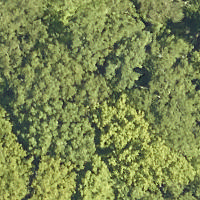

In [50]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the bounding boxes.

17


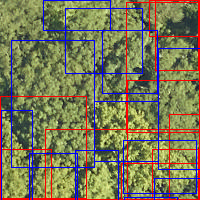

In [51]:
from PIL import Image, ImageDraw

bb_img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
bb_draw_img = ImageDraw.Draw(bb_img)

# Predicted boxes
boxes = prediction[0]['boxes']
for box in boxes[:10]:
  box = [int(coord) for coord in box]
  shape = [(box[1], box[0]), (box[3], box[2])]
  bb_draw_img.rectangle(shape, outline ="red", width=1)

# Correct boxes
boxes = correct['boxes']
for box in boxes:
  box = [int(coord) for coord in box]
  shape = [(box[1], box[0]), (box[3], box[2])]
  bb_draw_img.rectangle(shape, outline ="blue", width=1)

print(len(boxes))
bb_img

Looks pretty good! ...in your dreams

## Wrapping up

In this tutorial, you have learned how to create your own training pipeline for instance segmentation models, on a custom dataset.
For that, you wrote a `torch.utils.data.Dataset` class that returns the images and the ground truth boxes and segmentation masks. You also leveraged a Mask R-CNN model pre-trained on COCO train2017 in order to perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-gpu training, check `references/detection/train.py`, which is present in the [torchvision GitHub repo](https://github.com/pytorch/vision/tree/v0.3.0/references/detection). 

